In [1]:
import pandas as pd
from joblib import dump, load
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
def synthetic_minority_over_sampling(output, all_columns_train):
    print('Original dataset shape {}'.format(Counter(output)))
    sm = SMOTE(random_state=20)
    train_input_new, train_output_new = sm.fit_resample(all_columns_train, output)
    print('New dataset shape {}'.format(Counter(train_output_new)))
    return train_input_new, train_output_new

In [3]:
def calc_prevalence(y_actual):
    # function to calculate if there is class impalance and prints it
    #
    # input : the output variable
    # 
    print(y_actual.value_counts()/len(y_actual))
    print(y_actual.value_counts())

In [23]:
np.random.seed(0)
all_columns_train = pd.read_csv('all_columns_train.csv')
all_columns_test = pd.read_csv('all_columns_test.csv')
output = pd.read_pickle('train_output.pkl')

In [5]:
all_columns_train.shape

(71236, 44)

In [24]:
all_columns_train['readmitted'] = output
frames = [all_columns_train, all_columns_test]
all_data = pd.concat(frames)
all_data["number of visits"]=all_data.patient_nbr.map(all_data.patient_nbr.value_counts())

all_columns_test = all_data[all_data['readmitted'].isna()]
del all_columns_test['readmitted']
all_columns_train = all_data[all_data['readmitted'].notna()]

In [25]:
#all_columns_train['number of visits'] = patient_nbr_prediction['number of visits']
del all_columns_train['patient_nbr']
del all_columns_test['patient_nbr']

In [26]:
del all_columns_train['readmitted']

## split dataset

In [9]:
features_train,features_valid,labels_train,labels_valid = train_test_split(all_columns_train,output,train_size=0.9)

In [10]:
#features_train, labels_train = synthetic_minority_over_sampling(labels_train, features_train)

In [11]:
calc_prevalence(labels_train)

NO     0.538807
>30    0.349311
<30    0.111882
Name: readmitted, dtype: float64
NO     34544
>30    22395
<30     7173
Name: readmitted, dtype: int64


In [12]:
calc_prevalence(labels_valid)

NO     0.541971
>30    0.348961
<30    0.109068
Name: readmitted, dtype: float64
NO     3861
>30    2486
<30     777
Name: readmitted, dtype: int64


In [13]:
def print_metrics_and_return_f1_score(model, features, labels):
    predictions = model.predict(features)
    f1 = f1_score(labels, predictions, average='micro')
    print("f1 is {0:.5f}".format(f1))
    #print("Precision is {0:.5f}".format(precision_score(labels, predictions, average='micro')))
    #print("Recall is {0:.5f}".format(recall_score(labels, predictions, average='micro')))
    #y_true = label_binarize(labels, classes=np.unique(labels))
    #y_predict = label_binarize(predictions, classes=np.unique(labels))
    #print("AUC is {0:.5f}".format(roc_auc_score(y_true, y_predict,average='micro')))
    return f1

In [14]:
def plot_confusion_matrix(model, encoder, c):
    ax= plt.subplot()
    sns.heatmap(c, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['<30', '>30', 'NO']); ax.yaxis.set_ticklabels(['<30', '>30', 'NO']);
    
    print(c.diagonal()/c.sum(axis=1))
    print(encoder.inverse_transform(model.classes_))

In [33]:
loss = ['hinge', 'log_loss']
penalty = ['l2', 'l1', 'elasticnet']
alpha_values = [10, 1.0, 0.1, 0.01]
grid = dict(penalty=penalty,alpha=alpha_values, loss=loss)
lr_model = SGDClassifier(random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
grid_search = GridSearchCV(estimator=lr_model, param_grid=grid, n_jobs=-1, cv=cv, verbose=1)
grid_result = grid_search.fit(features_train, labels_train)

#print_metrics_and_return_f1_score(grid_result.best_estimator_, features_train, labels_train)
print_metrics_and_return_f1_score(grid_result.best_estimator_, features_valid, labels_valid)
print(grid_result.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
f1 is 0.66395
{'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l2'}


## Random forest

In [34]:
n_estimators = [300, 400, 500]
min_samples_split = [20, 30, 10, 40]
grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split)
rf_model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, n_jobs=-1, verbose=1)
grid_result = grid_search.fit(features_train, labels_train)

#print_metrics_and_return_f1_score(grid_result.best_estimator_, features_train, labels_train)
print_metrics_and_return_f1_score(grid_result.best_estimator_, features_valid, labels_valid)
print(grid_result.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


f1 is 0.72712
{'min_samples_split': 20, 'n_estimators': 500}


In [35]:
adamodel = AdaBoostClassifier(random_state=0)
adamodel.fit(features_train,labels_train)
print_metrics_and_return_f1_score(adamodel, features_valid, labels_valid)

f1 is 0.70929


0.709292532285233

In [83]:
"""from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=labels_train_
)
, sample_weight=classes_weights"""

"from sklearn.utils import class_weight\nclasses_weights = class_weight.compute_sample_weight(\n    class_weight='balanced',\n    y=labels_train_\n)\n, sample_weight=classes_weights"

In [15]:
le = preprocessing.LabelEncoder()
labels_train_ = le.fit_transform(labels_train)
labels_valid_ = le.transform(labels_valid)
xgb_model = XGBClassifier(max_depth=4, random_state=0)
xgb_model.fit(features_train,labels_train_)
xgb_model.score(features_valid,labels_valid_)

0.7297866367209432

[0.03861004 0.65164924 0.91919192]
['<30' '>30' 'NO']


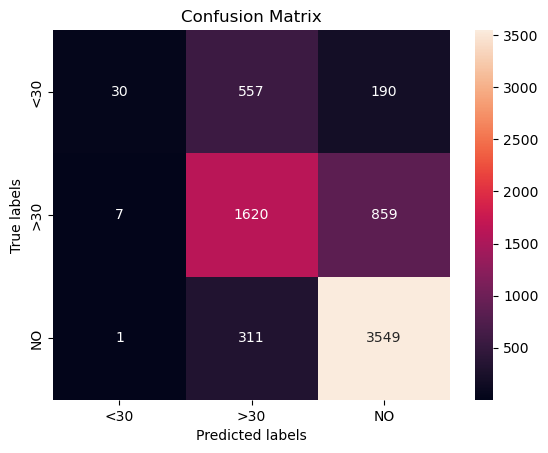

In [16]:
c = confusion_matrix(labels_valid_, xgb_model.predict(features_valid))
plot_confusion_matrix(model = xgb_model, encoder = le, c=c)

## voting classifier

In [17]:
from sklearn.ensemble import VotingClassifier
#clf1 = SGDClassifier(random_state=0, alpha = .01, loss = 'log_loss', penalty='l2')
clf2 = RandomForestClassifier(n_estimators=500, min_samples_split=40, random_state=0)
clf3 = XGBClassifier(max_depth=4, random_state=0)
clf4 = AdaBoostClassifier(random_state=0)

le = preprocessing.LabelEncoder()
labels_train_ = le.fit_transform(labels_train)
labels_valid_ = le.transform(labels_valid)

eclf1 = VotingClassifier(estimators=[
        ('rf', clf2), ('xg', clf3), ('ada', clf4)], voting='soft')
eclf1.fit(features_train,labels_train_)
eclf1.score(features_valid,labels_valid_)

0.728663672094329

[0.02187902 0.66251006 0.91349391]
['<30' '>30' 'NO']


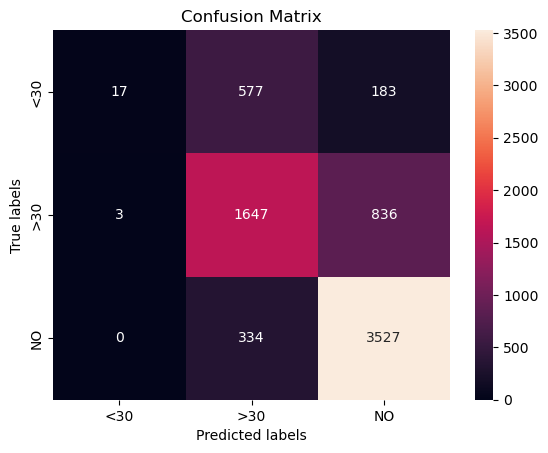

In [18]:
c = confusion_matrix(labels_valid_, eclf1.predict(features_valid))
plot_confusion_matrix(model = eclf1, encoder = le, c=c)

## blender

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
clf1 = SGDClassifier(random_state=0, alpha = .01, loss = 'log_loss', penalty='l2')
clf2 = RandomForestClassifier(n_estimators=500, min_samples_split=40, random_state=0)
clf3 = XGBClassifier(max_depth=4, random_state=0)
clf4 = AdaBoostClassifier(random_state=0)

le = preprocessing.LabelEncoder()
labels_train_ = le.fit_transform(labels_train)
labels_valid_ = le.transform(labels_valid)
estimators=[('lr', clf1), ('rf', clf2), ('xg', clf3), ('ada', clf4)]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(features_train,labels_train_)
clf.score(features_valid,labels_valid_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7307692307692307

In [36]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=30)
neigh.fit(features_train,labels_train)
neigh.score(features_valid, labels_valid)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.684727681078046

## Generating submission file

In [22]:
pred = le.inverse_transform(clf.predict(all_columns_test))
test_data = pd.read_csv("test.csv")
test_data['readmitted'] = pred
test_data[['encounter_id', 'readmitted']].to_csv('best_model2.csv', index=False)

In [50]:
pred = grid_result.best_estimator_.predict(all_columns_test)
test_data = pd.read_csv("test.csv")
test_data['readmitted'] = pred
test_data[['encounter_id', 'readmitted']].to_csv('submission.csv', index=False)

In [49]:
pred

array(['NO', 'NO', 'NO', ..., 'NO', '>30', 'NO'], dtype=object)